<a href="https://colab.research.google.com/github/taddbackus/CaseStudy2DDS/blob/main/SVM%20and%20LR/Mini-Lab_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Contributors
* Tadd Backus
* Kendall Scott
* Austin Webb
* Milan Patel


In [1]:
from IPython.display import HTML
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')

In [15]:
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import SGDClassifier

pd.set_option('display.max_columns',None)

import warnings
warnings.filterwarnings('ignore')

In [7]:
forest_cover_type = pd.read_csv('covtype.csv')
forest_cover_type.head()
# Creating a new dataset that only contains the most common cover types
#updated to all
# Renaming wilderness areas
forestDF = forest_cover_type
forestDF.rename(columns={'Wilderness_Area1':'Rawah','Wilderness_Area2':'Neota','Wilderness_Area3':'Comanche Peak','Wilderness_Area4':'Cache la Poudre'},inplace=True)
forestDF.head()


# Coding Lodgepole Pine as 1 and Spruce/Fir as 0

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Rawah,Neota,Comanche Peak,Cache la Poudre,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5


In [8]:
#New dataframe that only contains two most common cover types
# 1 -> Spruce/Fir
# 2 -> Lodgepole Pine

forestDF = forest_cover_type[(forest_cover_type['Cover_Type']==1) | (forest_cover_type['Cover_Type']==2)]

In [9]:
forestDF = forestDF.astype({'Cover_Type':'string'})
forestDF['Cover_Type'] = forestDF['Cover_Type'].str.replace('1','Spruce/Fir')
forestDF['Cover_Type'] = forestDF['Cover_Type'].str.replace('2','Lodgepole Pine')
forestDF['Cover_Type'].describe().transpose()

count             495141
unique                 2
top       Lodgepole Pine
freq              283301
Name: Cover_Type, dtype: object

In [10]:
# Lodgepole Pine = 1 | Spruce/Fir = 0
forestDF['treeType'] = forestDF.Cover_Type == 'Lodgepole Pine'
forestDF.treeType = forestDF.treeType.astype(np.int64)
if 'Cover_Type' in forestDF:
    del forestDF['Cover_Type']


In [11]:
forestFullDF = forestDF.copy()

## Create Models
For our models, we decided to predict if a certain land plot is Spruce/Fir or Lodegpole Pine.

After comparing the results, we will make a recommendation for which model to implement in order to predict Cover Type.


## Create Models 50

# From Rubric delete before submitting
Create a logistic regression model and a support vector machine model for the classification task involved with your dataset. 
Assess how well each model performs (use 80/20 training/testing split for your data). 
Adjust parameters of the models to make them more accurate. 
If your dataset size requires the use of stochastic gradient descent, then linear kernel only is fine to use. 
That is, the SGDClassifier is fine to use for optimizing logistic regression and linear support vector machines. For many problems, SGD will be required in order to train the SVM model in a reasonable timeframe. 

# Quick Model run through
The following sections create and train two models on the dataset: Logistic Regression and SVM. For SVM, due to the large amount of records in the dataset we will be using Stochastic Gradient Descent.

# Logistic Regression

In [12]:
if 'treeType' in forestDF:
    Y = forestDF['treeType'].values
    del forestDF['treeType']
    X = forestDF.values

In [13]:
#Creating cross validation object
num_cv_iter = 10
num_instances = len(Y)
cv_Log = ShuffleSplit(n_splits=num_cv_iter,test_size=0.2)

In [14]:
# Creating logistic regression object
lr_clf = LogisticRegression(penalty = 'l2',
                            C = 1.0,
                            class_weight = None)

In [16]:
# Running logistic regression on 10 random test/train splits
iter_num = 0

for iter_num, (train_indices,test_indices) in enumerate(cv_Log.split(X,Y)):
    lr_clf.fit(X[train_indices],Y[train_indices])
    y_hat = lr_clf.predict(X[test_indices])
    
    print('****Iteration',iter_num,'****')
    print('Accuracy',mt.accuracy_score(Y[test_indices],y_hat))
    print('Confusion Matrix \n',mt.confusion_matrix(Y[test_indices],y_hat))

    

****Iteration 0 ****
Accuracy 0.7447111452200871
Confusion Matrix 
 [[28571 13894]
 [11387 45177]]
****Iteration 1 ****
Accuracy 0.7386321178644639
Confusion Matrix 
 [[28919 13416]
 [12467 44227]]
****Iteration 2 ****
Accuracy 0.751204192711226
Confusion Matrix 
 [[29479 12881]
 [11757 44912]]
****Iteration 3 ****
Accuracy 0.7561118460249018
Confusion Matrix 
 [[29612 12862]
 [11290 45265]]
****Iteration 4 ****
Accuracy 0.7613830292136646
Confusion Matrix 
 [[29626 12848]
 [10782 45773]]
****Iteration 5 ****
Accuracy 0.7566167486291895
Confusion Matrix 
 [[29404 12743]
 [11359 45523]]
****Iteration 6 ****
Accuracy 0.7591311635985418
Confusion Matrix 
 [[29625 12804]
 [11049 45551]]
****Iteration 7 ****
Accuracy 0.7610497934948348
Confusion Matrix 
 [[29773 12757]
 [10906 45593]]
****Iteration 8 ****
Accuracy 0.7603732240050894
Confusion Matrix 
 [[29889 12631]
 [11099 45410]]
****Iteration 9 ****
Accuracy 0.7572933181189349
Confusion Matrix 
 [[29569 12726]
 [11309 45425]]


In [19]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(lr_clf, X, Y, cv=cv_Log)


[0.75289057 0.74891193 0.75826273 0.75276939 0.75712165 0.74679134
 0.75748518 0.73865231 0.75728322 0.75509194]


In [25]:
print('The mean accuracy was',np.mean(accuracies)*100,'% after',num_cv_iter,'cross validations.')

The mean accuracy was 75.25260277292512 % after 10 cross validations.


After the logistic regression model was run ten times, the mean accuracy score was 75% This shows us that the different train/test splits seem to be fair in their distributions. We do anticipate a change in accuracy (an increase) as we attempt to adjust some parameters and implement other measures. 

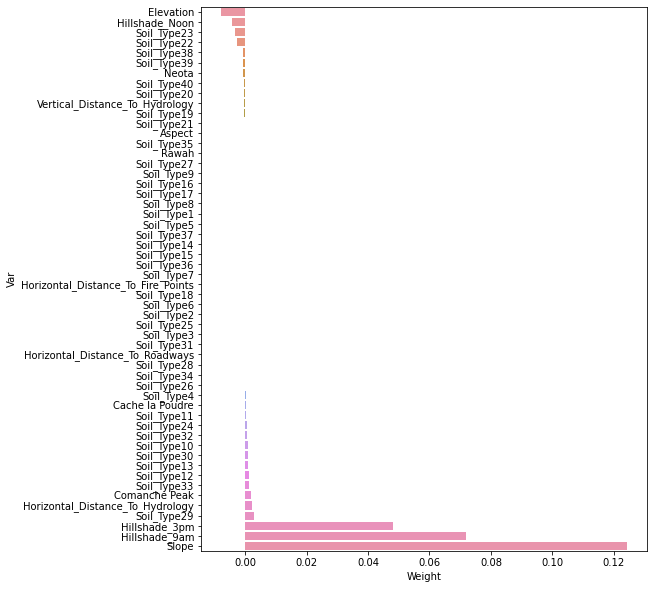

In [26]:
logWeights = pd.Series(lr_clf.coef_[0], index = forestDF.columns)
logWeights = pd.DataFrame({'Var':logWeights.index, 'Weight':logWeights.values})
logWeights = logWeights.sort_values('Weight')
plt.figure(figsize=(8, 10))
sns.barplot(x='Weight', y = 'Var', data = logWeights)

The above weights are not scaled so we will reassess after scaling the predictors.

In [31]:
sclObj = StandardScaler()
sclObj.fit(X)

XScaled = sclObj.transform(X)

lrs_clf = LogisticRegression(penalty='l2',
                             C=150.0,
                             class_weight=None)
iter_num = 0 
for iter_num, (train_indices,test_indices) in enumerate(cv_Log.split(XScaled,Y)):
  lrs_clf.fit(XScaled[train_indices],Y[train_indices])
  y_hatS = lrs_clf.predict(XScaled[test_indices])
  print('****Iteration',iter_num,'****')
  print('Accuracy',mt.accuracy_score(Y[test_indices],y_hatS))
  print('Confusion Matrix \n',mt.confusion_matrix(Y[test_indices],y_hatS))

****Iteration 0 ****
Accuracy 0.7774591281341829
Confusion Matrix 
 [[30383 11849]
 [10189 46608]]
****Iteration 1 ****
Accuracy 0.7741065748417131
Confusion Matrix 
 [[30358 12060]
 [10310 46301]]
****Iteration 2 ****
Accuracy 0.7762675579880641
Confusion Matrix 
 [[30581 11893]
 [10263 46292]]
****Iteration 3 ****
Accuracy 0.7765503034464651
Confusion Matrix 
 [[30379 12027]
 [10101 46522]]
****Iteration 4 ****
Accuracy 0.7743893203001141
Confusion Matrix 
 [[30211 12097]
 [10245 46476]]
****Iteration 5 ****
Accuracy 0.7749851053731736
Confusion Matrix 
 [[30483 11953]
 [10330 46263]]
****Iteration 6 ****
Accuracy 0.7752678508315746
Confusion Matrix 
 [[30444 11983]
 [10272 46330]]
****Iteration 7 ****
Accuracy 0.7779135404780417
Confusion Matrix 
 [[30363 11951]
 [10042 46673]]
****Iteration 8 ****
Accuracy 0.7758737339567198
Confusion Matrix 
 [[30243 12066]
 [10129 46591]]
****Iteration 9 ****
Accuracy 0.7754799099253754
Confusion Matrix 
 [[30433 12061]
 [10173 46362]]


In [32]:
from sklearn.model_selection import cross_val_score
accScaled = cross_val_score(lrs_clf, XScaled, Y, cv=cv_Log)
print('The mean accuracy was',np.mean(accScaled)*100,'% after',num_cv_iter,'cross validations.')

The mean accuracy was 77.58181946702481 % after 10 cross validations.


After scaling the predictors and changing the C hyperparameter to 150 the mean accuracy of our model after 10 cross validation iterations increased to 77.5%.

Next we'll look at the weights of the predictors after the scaling.

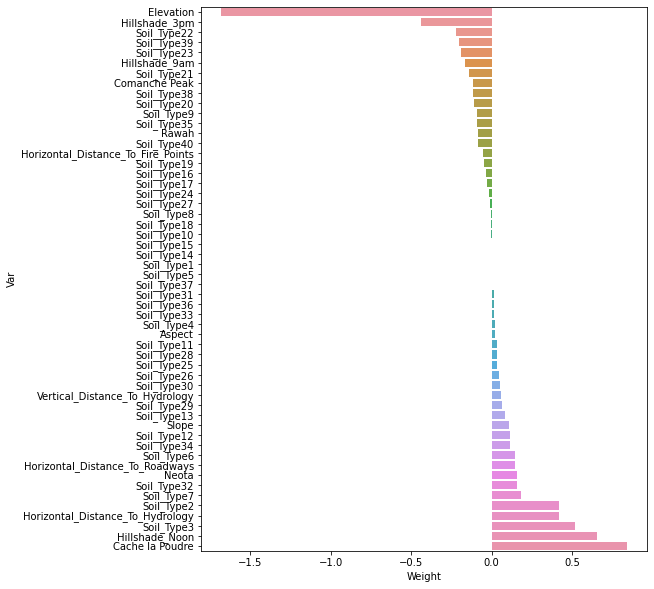

In [33]:
logSWeights = pd.Series(lrs_clf.coef_[0],index=forestDF.columns)
logSWeights = pd.DataFrame({'Var':logSWeights.index,'Weight':logSWeights.values})
logSWeights = logSWeights.sort_values('Weight')
plt.figure(figsize=(8,10))
sns.barplot(x='Weight',y='Var',data=logSWeights)

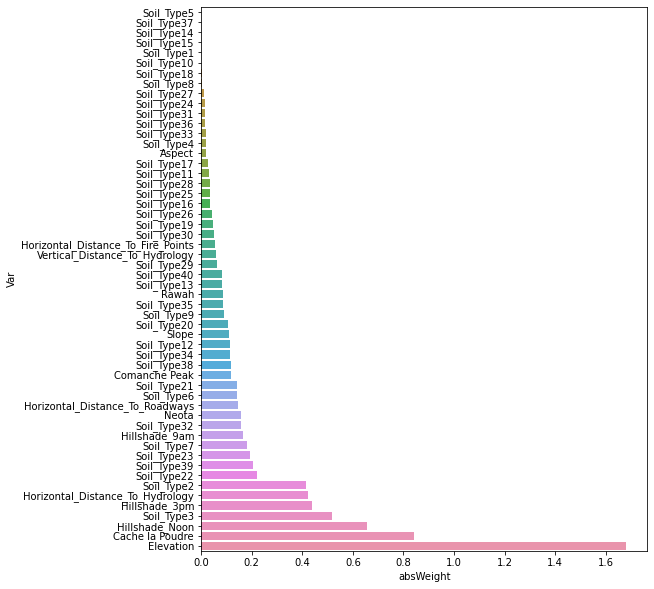

In [35]:
logSWeights['absWeight'] = logSWeights['Weight'].abs()
logSWeights = logSWeights.sort_values('absWeight')
plt.figure(figsize=(8,10))
sns.barplot(x='absWeight',y='Var',data=logSWeights)

We decided to leverage Random Forest to eliminate some of the variables included in the model, to see if there is an increase in performance in a simpler model.

In [ ]:
# Feature Importance Graph
# Takes about five minutes
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators = 20)
rf.fit(X, Y)

RandomForestRegressor(n_estimators=20)

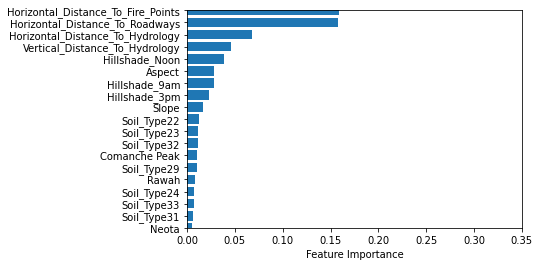

In [ ]:
sort = rf.feature_importances_.argsort()
plt.barh(forestDF.columns.values[sort], rf.feature_importances_[sort])
plt.xlabel('Feature Importance')
plt.axis([0, 0.35, 34, 52])
plt.show()

In [ ]:
forestDF.columns

Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Rawah', 'Neota', 'Comanche Peak',
       'Cache la Poudre', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3',
       'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8',
       'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12',
       'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16',
       'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
       'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
       'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
       'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
       'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
       'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40'],
      dtype='object')

Based on the importance output, we decided to build a simplified model on:

*   Elevation
*   Horizontal Distance to Fire Points
*   Soil Type: 32, 4, 2, 23, 29, 33, 31, 22
*   Horizontal Distance to Roadways
*   Wilderness Area: Comanche Peak, Rawah
*   Horizontal Distance To Hydrology
*   Hillshade noon
*   Aspect
*   Slope




In [ ]:
forestDF_new = pd.DataFrame().assign(
                treeType=Y, 
                Elevation=forestDF['Elevation'], 
                Horizontal_Distance_To_Fire_Points=forestDF['Horizontal_Distance_To_Fire_Points'],
                Soil_Type32=forestDF['Soil_Type32'],
                Soil_Type4=forestDF['Soil_Type4'],
                Soil_Type2=forestDF['Soil_Type2'],
                Soil_Type23=forestDF['Soil_Type23'],
                Soil_Type29=forestDF['Soil_Type29'],
                Soil_Type33=forestDF['Soil_Type33'],
                Soil_Type31=forestDF['Soil_Type31'],
                Soil_Type22=forestDF['Soil_Type22'],
                Horizontal_Distance_To_Roadways=forestDF['Horizontal_Distance_To_Roadways'],
                Comanche_Peak=forestDF['Comanche Peak'], 
                Rawah=forestDF['Rawah'], 
                Horizontal_Distance_To_Hydrology=forestDF['Horizontal_Distance_To_Hydrology'],
                Hillshade_Noon=forestDF['Hillshade_Noon'],
                Aspect=forestDF['Aspect'],
                Slope=forestDF['Slope']
                                                      )


In [ ]:
# Assign specific features to two different variables
if 'treeType' in forestDF:
    Y = forestDF_new['treeType'].values
    del forestDF_new['treeType']
    X = forestDF_new.values

In [ ]:
# Re-creating logistic regression object
lr_clf_new = LogisticRegression(penalty = 'l2', C = 1.0, class_weight = None)

In [ ]:
#Running logistic regression on 10 random test/train splits with simplified model
iter_num = 0

for iter_num, (train_indices,test_indices) in enumerate(cv_object.split(X,Y)):
    lr_clf_new.fit(X[train_indices],Y[train_indices])
    y_hat = lr_clf_new.predict(X[test_indices])
    
    print('****Iteration',iter_num,'****')
    print('Accuracy',mt.accuracy_score(Y[test_indices],y_hat))
    print('Confusion Matrix \n',mt.confusion_matrix(Y[test_indices],y_hat))
    

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


****Iteration 0 ****
Accuracy 0.7473770309707257
Confusion Matrix 
 [[28488 13809]
 [11208 45524]]


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


****Iteration 1 ****
Accuracy 0.7574245927960497
Confusion Matrix 
 [[29684 12939]
 [11083 45323]]


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


****Iteration 2 ****
Accuracy 0.7413181997192742
Confusion Matrix 
 [[27622 14453]
 [11164 45790]]


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


****Iteration 3 ****
Accuracy 0.7519918407739147
Confusion Matrix 
 [[29471 13086]
 [11474 44998]]


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


****Iteration 4 ****
Accuracy 0.7480334043562997
Confusion Matrix 
 [[28630 13792]
 [11160 45447]]


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


****Iteration 5 ****
Accuracy 0.7584343980046249
Confusion Matrix 
 [[29509 12856]
 [11066 45598]]


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


****Iteration 6 ****
Accuracy 0.7592725363277424
Confusion Matrix 
 [[29577 12841]
 [10998 45613]]


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


****Iteration 7 ****
Accuracy 0.7374910379787739
Confusion Matrix 
 [[27671 14801]
 [11195 45362]]


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


****Iteration 8 ****
Accuracy 0.7533853719617486
Confusion Matrix 
 [[28699 13731]
 [10691 45908]]
****Iteration 9 ****
Accuracy 0.7541528239202658
Confusion Matrix 
 [[29482 13183]
 [11163 45201]]


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Interpret Feature Importance 30

Use the weights from logistic regression to interpret the importance of different features for the classification task. Explain your interpretation in detail. Why do you think some variables are more important?

## Looking at weights of the model

In [ ]:
weights = lr_clf_new.coef_.T
varNames = forestDF_new.columns
for coef, name in zip(weights, varNames):
    print(name, 'has weight of', coef[0])

treeType has weight of -0.008091646234095607
Elevation has weight of -0.0007445785326487877
Horizontal_Distance_To_Fire_Points has weight of 0.10778110672300177
Soil_Type32 has weight of 0.002845857827168386
Soil_Type4 has weight of 0.0006102651178818677
Soil_Type2 has weight of 2.153616418616753e-05
Soil_Type23 has weight of 0.06924963742059297
Soil_Type29 has weight of 0.004695529587159764
Soil_Type33 has weight of 0.047656483324137744
Soil_Type31 has weight of 2.8982219219835415e-07
Soil_Type22 has weight of -4.847403177666305e-05
Horizontal_Distance_To_Roadways has weight of -0.000549816410821631
Comanche_Peak has weight of 0.0016366394340241758
Rawah has weight of 0.00013316637742155388
Horizontal_Distance_To_Hydrology has weight of 0.0
Hillshade_Noon has weight of 2.9277631870266794e-05
Aspect has weight of 4.007537392841114e-05
Slope has weight of 9.74065868746987e-05


The weights from the logistic regression model help us identify the importance of the various features. Having so many differnet features, it can be nice to see which ones impact the classification more so than others. This way, we can use those of utomst importance to create a better/more accurate model. 

We can see from the graph these weights for the various features quite nicely. The graph shows us that 'Elevation' has the largest absolute value. This allows us to assume that it plays the largest role in classification, in regard to all the other features in this dataset. Cache la Poudre is the next highest value. 

We believe that certain features have higher weights due to their immediate connection with the clasification. The Spruce/Fir trees grow best in certain conditions; some of these conditions are listed in the features. We believe that elevation is a key driver in identifying whether a tree is a Spruce/Fir. Similarly, we believe that other features directly connect to Spruce/Fir - like soil type.   

# Support Vector Machine

### Creating and running the SVM using the scaled and split sets from earlier

In [ ]:
# Creating Cross Validation Object - SVM
cv_CGD = StratifiedShuffleSplit(n_splits = 3, test_size = 0.2)

In [ ]:
#Creating SVM using linear SGD due to large amount of data
regularize_const = 0.1
iterations = 10

svm_sgd = SGDClassifier(alpha=regularize_const,
                       fit_intercept = True,
                       l1_ratio = 0.0,
                       learning_rate = 'optimal',
                       loss = 'hinge',
                       max_iter = iterations,
                       n_jobs = -1,
                       penalty = 'l2')

In [ ]:
scl = StandardScaler()

for train_idx, test_idx in cv_CGD.split(X,Y):
    svm_sgd.fit(scl.fit_transform(X[train_idx]), Y[train_idx])
    y_hatSVM = svm_sgd.predict(scl.transform(X[test_idx]))
    
    print('Accuracy', mt.accuracy_score(Y[test_idx], y_hatSVM))
    print('Confusion Matrix \n', mt.confusion_matrix(Y[test_idx], y_hatSVM))

Accuracy 0.764432640943562
Confusion Matrix 
 [[27829 14539]
 [ 8789 47872]]
Accuracy 0.7652707792666794
Confusion Matrix 
 [[27955 14413]
 [ 8832 47829]]
Accuracy 0.7650385240687071
Confusion Matrix 
 [[27928 14440]
 [ 8828 47833]]


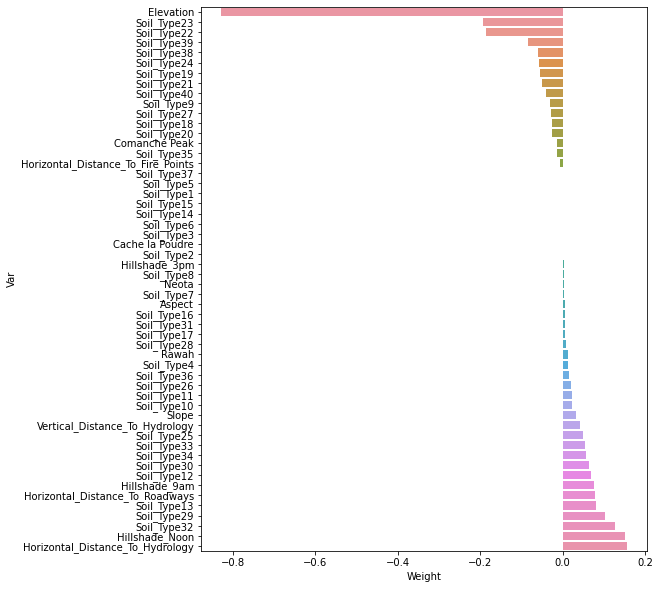

In [ ]:
SVMWeights = pd.Series(svm_sgd.coef_[0], index = forestDF.columns)
SVMWeights = pd.DataFrame({'Var':SVMWeights.index, 'Weight':SVMWeights.values})
SVMWeights = SVMWeights.sort_values('Weight')
plt.figure(figsize = (8, 10))
sns.barplot(x = 'Weight', y = 'Var', data = SVMWeights)

In [ ]:
# Creating SVM using logistic SGD due to large amount of data
log_sgd = SGDClassifier(alpha = regularize_const,
                       fit_intercept = True,
                       l1_ratio = 0.0,
                       learning_rate = 'optimal',
                       loss = 'log',
                       max_iter = iterations,
                       n_jobs = -1,
                       penalty = 'l2')

In [ ]:
scl = StandardScaler()

for train_idx, test_idx in cv_CGD.split(X,Y):
    log_sgd.fit(scl.fit_transform(X[train_idx]), Y[train_idx])
    y_hatSVM = log_sgd.predict(scl.transform(X[test_idx]))
    
    print('Accuracy', mt.accuracy_score(Y[test_idx], y_hatSVM))
    print('Confusion Matrix \n', mt.confusion_matrix(Y[test_idx], y_hatSVM))

Accuracy 0.7655030344646517
Confusion Matrix 
 [[27673 14695]
 [ 8527 48134]]
Accuracy 0.7629785214432137
Confusion Matrix 
 [[27542 14826]
 [ 8646 48015]]
Accuracy 0.7636853850892162
Confusion Matrix 
 [[27377 14991]
 [ 8411 48250]]


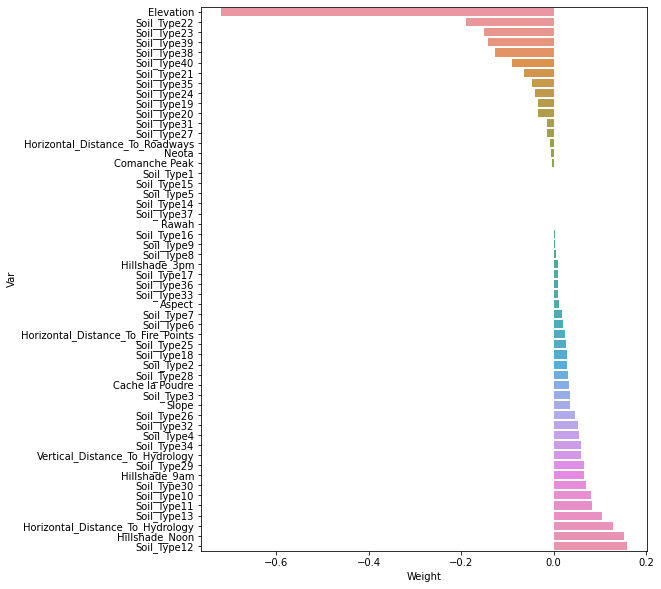

In [ ]:
logSVMWeights = pd.Series(log_sgd.coef_[0],index = forestDF.columns)
logSVMWeights = pd.DataFrame({'Var':logSVMWeights.index, 'Weight':logSVMWeights.values})
logSVMWeights = logSVMWeights.sort_values('Weight')
plt.figure(figsize = (8, 10))
sns.barplot(x = 'Weight', y = 'Var', data = logSVMWeights)

In [ ]:
# Sub-sampling data and verifying still balanced
forestSubDF = forestFullDF.sample(10000)
forestSubDF.head()
# forestSubDF['treeType'].describe().transpose()
forestSubDF.groupby('treeType').count()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Rawah,Neota,Comanche Peak,Cache la Poudre,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
treeType,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,4278,4278,4278,4278,4278,4278,4278,4278,4278,4278,4278,4278,4278,4278,4278,4278,4278,4278,4278,4278,4278,4278,4278,4278,4278,4278,4278,4278,4278,4278,4278,4278,4278,4278,4278,4278,4278,4278,4278,4278,4278,4278,4278,4278,4278,4278,4278,4278,4278,4278,4278,4278,4278,4278
1,5722,5722,5722,5722,5722,5722,5722,5722,5722,5722,5722,5722,5722,5722,5722,5722,5722,5722,5722,5722,5722,5722,5722,5722,5722,5722,5722,5722,5722,5722,5722,5722,5722,5722,5722,5722,5722,5722,5722,5722,5722,5722,5722,5722,5722,5722,5722,5722,5722,5722,5722,5722,5722,5722


In [ ]:
# Creating and Running SVM model on smaller dataframe
if 'treeType' in forestSubDF:
    ySub = forestSubDF['treeType'].values
    del forestSubDF['treeType']
    xSub = forestSubDF.values

In [ ]:
num_cv_iter = 10
num_instances = len(Y)
cv_Log = ShuffleSplit(n_splits = num_cv_iter, test_size = 0.2)

In [ ]:
for train_indices, test_indices in cv_Log.split(xSub, ySub):
    X_train = xSub[train_indices]
    Y_train = ySub[train_indices]
    X_test = xSub[test_indices]
    Y_test = ySub[test_indices]
X_train_scaled = sclObj.transform(X_train)
X_test_scaled = sclObj.transform(X_test)

In [ ]:

svm_clf = SVC(C = 0.5,
             kernel = 'rbf',
             degree = 3,
             gamma = 'auto')

In [ ]:
# Results
svm_clf.fit(X_train_scaled,Y_train)
y_hatSVM = svm_clf.predict(X_test_scaled)
print('Accuracy', mt.accuracy_score(Y_test, y_hatSVM))
print('Confusion Matrix \n', mt.confusion_matrix(Y_test, y_hatSVM))

Accuracy 0.782
Confusion Matrix 
 [[641 240]
 [196 923]]


In [ ]:
# Support Vector shape:
print(svm_clf.support_vectors_.shape)
print(svm_clf.support_.shape)
print(svm_clf.n_support_)

(4558, 54)
(4558,)
[2272 2286]


In [ ]:
forestTested = forestSubDF.iloc[train_indices]
forestSupport = forestTested.iloc[svm_clf.support_,:]
forestSupport['treeType'] = ySub[svm_clf.support_]
forestSubDF['treeType'] = ySub

<ipython-input-141-24464350875f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forestSupport['treeType'] = ySub[svm_clf.support_]


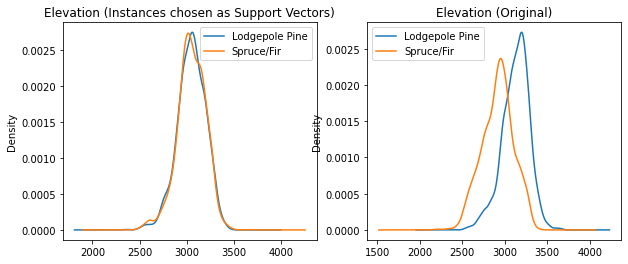

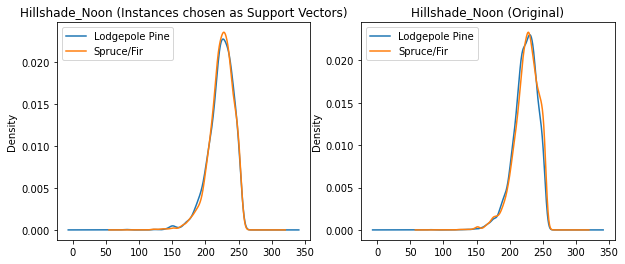

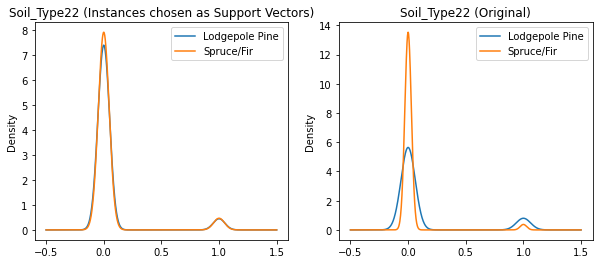

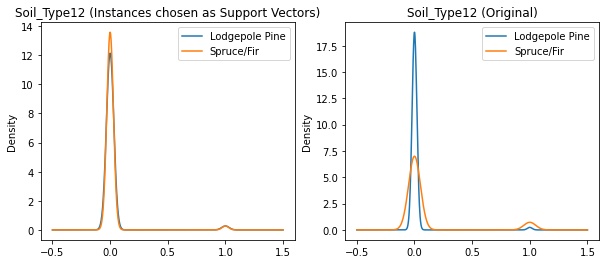

In [ ]:
forestGroupSupport = forestSupport.groupby(['treeType'])
forestGroup = forestSubDF.groupby(['treeType'])

vars_to_plot = ['Elevation', 'Hillshade_Noon', 'Soil_Type22', 'Soil_Type12']

for v in vars_to_plot:
    plt.figure(figsize = (10, 4))
    plt.subplot(1, 2, 1)
    ax = forestGroupSupport[v].plot.kde()
    plt.legend(['Lodgepole Pine', 'Spruce/Fir'])
    plt.title(v + ' (Instances chosen as Support Vectors)')
    
    plt.subplot(1,2,2)
    ax = forestGroup[v].plot.kde()
    plt.legend(['Lodgepole Pine', 'Spruce/Fir'])
    plt.title(v + ' (Original)')


## Create Models 50

Create a logistic regression model and a support vector machine model for the classification task involved with your dataset. 
Assess how well each model performs (use 80/20 training/testing split for your data). 
Adjust parameters of the models to make them more accurate. 
If your dataset size requires the use of stochastic gradient descent, then linear kernel only is fine to use. 
That is, the SGDClassifier is fine to use for optimizing logistic regression and linear support vector machines. For many problems, SGD will be required in order to train the SVM model in a reasonable timeframe. 

The SVM performed better than the logistic regression model. We see that the SVM gave us an accuracy score of 76%. This is a decent amount higher than the logistic score of 61%. We feel like there is still some room for improvement, but we are glad that we are seeing a higher accuracy score. 

## Interpret Support Vectors(10)

Look at the chosen support vectors for the classification task. Do these provide any insight into the data? Explain. If you used stochastic gradient descent (and therefore did not explicitly solve for support vectors), try subsampling your data to train the SVC model— then analyze the support vectors from the subsampled dataset.

Looking at some of the support vectors that were chosen, we can see that they greatly affect the outcome of the calssification. The graphs above do a great job illustrating the change in accuracy when comparing the original and the Support Vector. The chosen support vectors allow us to maximise the margin between vectors. This means that our classification plane is as wide as possible. This helps us to better classify, without having too many outliers or misclassifications. 

## Model Advantages 10
Discuss the advantages of each model for each classification task. Does one type of model offer superior performance over another in terms of prediction accuracy? In terms of training time or efficiency? Explain in detail.

The interpretability of Logistic Regression was fairly easy and understandable. This model also allowed for an easier way to see various accuracy scores for different train/test splits. We were able to create a loop that goes through different train/test splits and run logistic regression on each one to compare accuracy scores. This helps us to understand the average accuracy, due to the chance a specific train/test split gives an anomaly.

The SVM model provided a better accuracy score, which shows its superiority to Logistic Regression in this particular case. And using certain plots, it is easier to visually see the outcome of the model. The SVM seemed to be slightly quicker than Logistic Regression as well. We can see that both models are decently quick to run, but the SVM is faster. 